# Normalizing Flows

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/borchero/pyblaze/blob/master/docs/examples/normalizing-flows.ipynb)
[![Download Jupyter Notebbok](https://img.shields.io/badge/Github-Download-brightgreen)](https://github.com/borchero/pyblaze/blob/master/docs/examples/normalizing-flows.ipynb)

**_Note: Explanations and theory will be added in the future._**

In [1]:
import sklearn.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
import pyblaze.nn as xnn
import pyblaze.plot as P
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.dpi'] = 150

## Data

In [2]:
data_unicluster = datasets.make_biclusters((4096, 2), 1, noise=0.3, minval=-2, maxval=2, random_state=17)[0]
data_tricluster = datasets.make_biclusters((4096, 2), 3, noise=0.1, minval=-2, maxval=2, random_state=14)[0]
data_moons = datasets.make_moons(4096, noise=0.05)[0]

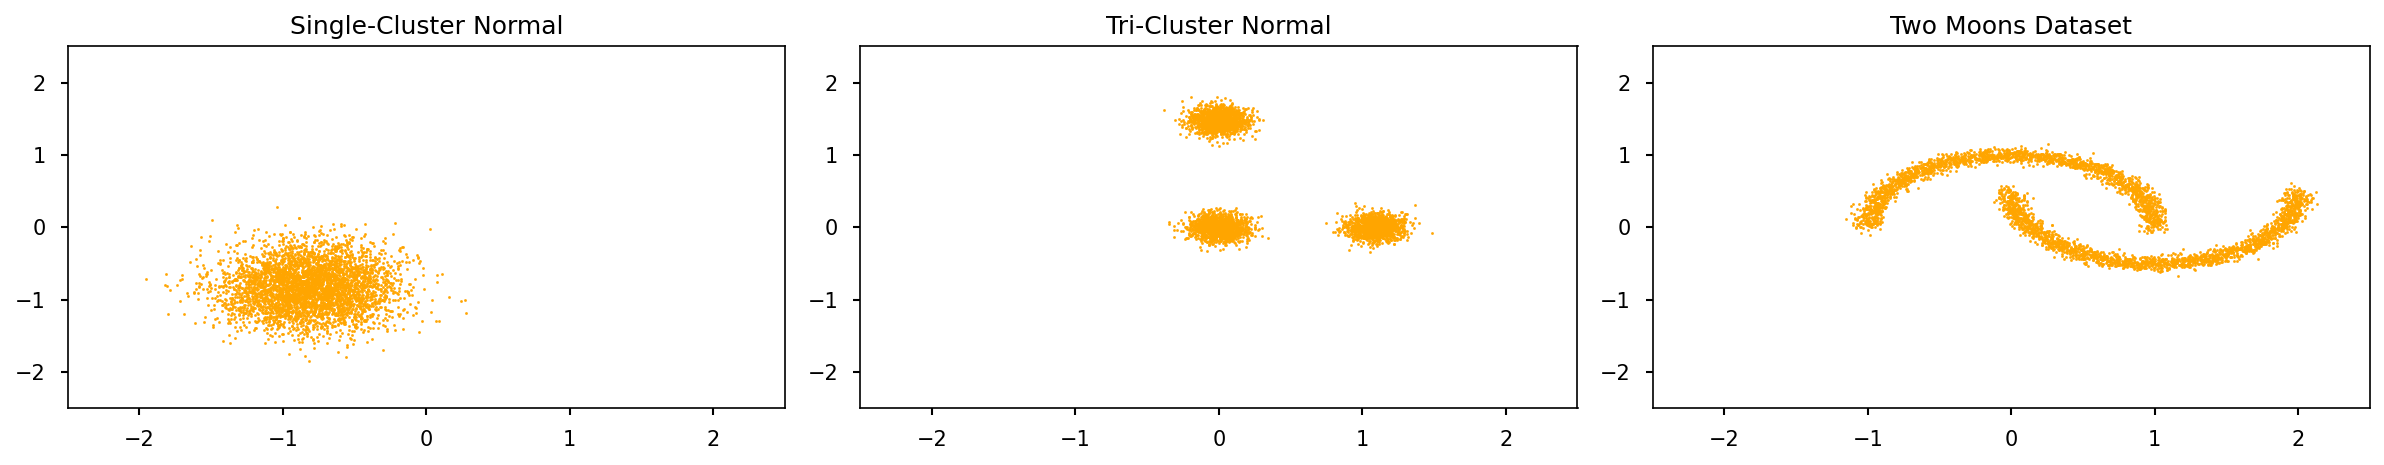

In [3]:
plt.figure(figsize=plt.figaspect(0.2))

plt.subplot(1, 3, 1)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_unicluster.T, s=1, color='orange')
plt.title('Single-Cluster Normal')

plt.subplot(1, 3, 2)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_tricluster.T, s=1, color='orange')
plt.title('Tri-Cluster Normal')

plt.subplot(1, 3, 3)
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
plt.scatter(*data_moons.T, s=1, color='orange')
plt.title('Two Moons Dataset')

plt.tight_layout()
plt.show()

In [4]:
def train(engine, data):
    data_ = torch.as_tensor(data, dtype=torch.float)
    loader = TensorDataset(data_).loader(batch_size=4096)
    
    optimizer = optim.Adam(engine.model.parameters(), lr=1e-2)

    return engine.train(
        loader,
        epochs=1000,
        optimizer=optimizer,
        loss=xnn.TransformedNormalLoss(),
        callbacks=[
            xnn.EpochProgressLogger(),
        ],
        gpu=False
    )

In [5]:
def train_and_plot_for_all(engine):
    plt.figure(figsize=plt.figaspect(0.2))
    loss = xnn.TransformedNormalLoss(reduction='none')

    print("Dataset (1/3)...")
    train(engine, data_unicluster)
    plt.subplot(1, 3, 1)
    P.density_plot2d(lambda x: torch.exp(-loss(*engine.model(x))), (-2.5, 2.5), (-2.5, 2.5))
    plt.colorbar()
    plt.scatter(*data_unicluster.T, s=3, color='orange', alpha=0.1)

    print("Dataset (2/3)...")
    train(engine, data_tricluster)
    plt.subplot(1, 3, 2)
    P.density_plot2d(lambda x: torch.exp(-loss(*engine.model(x))), (-2.5, 2.5), (-2.5, 2.5))
    plt.colorbar()
    plt.scatter(*data_tricluster.T, s=3, color='orange', alpha=0.1)

    print("Dataset (3/3)...")
    train(engine, data_moons)
    plt.subplot(1, 3, 3)
    P.density_plot2d(lambda x: torch.exp(-loss(*engine.model(x))), (-2.5, 2.5), (-2.5, 2.5))
    plt.colorbar()
    plt.scatter(*data_moons.T, s=3, color='orange', alpha=0.1)

    plt.show()

## Transformations

### Affine Transform

Dataset (1/3)...
 [Elapsed 0:00:29 | 34.31 it/s]                                                      
Dataset (2/3)...
 [Elapsed 0:00:28 | 35.68 it/s]                                                      
Dataset (3/3)...
 [Elapsed 0:00:23 | 41.75 it/s]                                                      


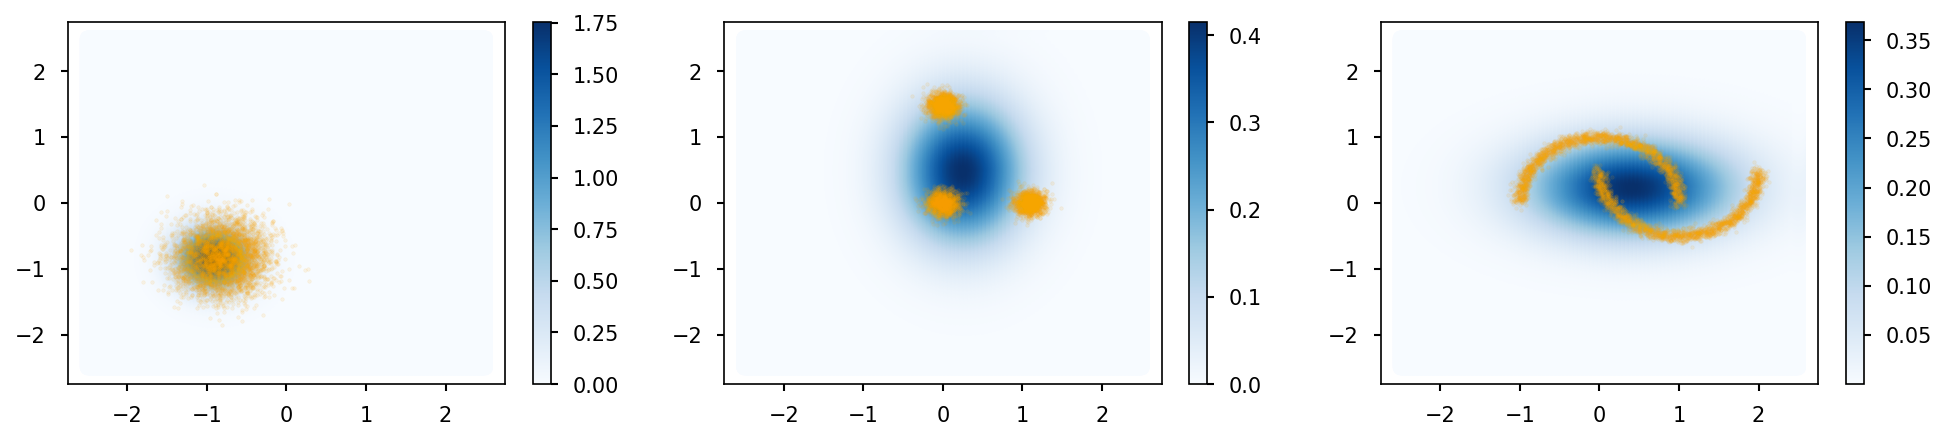

In [6]:
affine_model = xnn.NormalizingFlow([xnn.AffineTransform(2)])
affine_engine = xnn.MLEEngine(affine_model, expects_data_target=False)
train_and_plot_for_all(affine_engine)

### Planar Transform

Dataset (1/3)...
 [Elapsed 0:01:04 | 15.41 it/s]                                                      
Dataset (2/3)...
 [Elapsed 0:01:03 | 15.84 it/s]                                                      
Dataset (3/3)...
 [Elapsed 0:01:02 | 16.05 it/s]                                                      


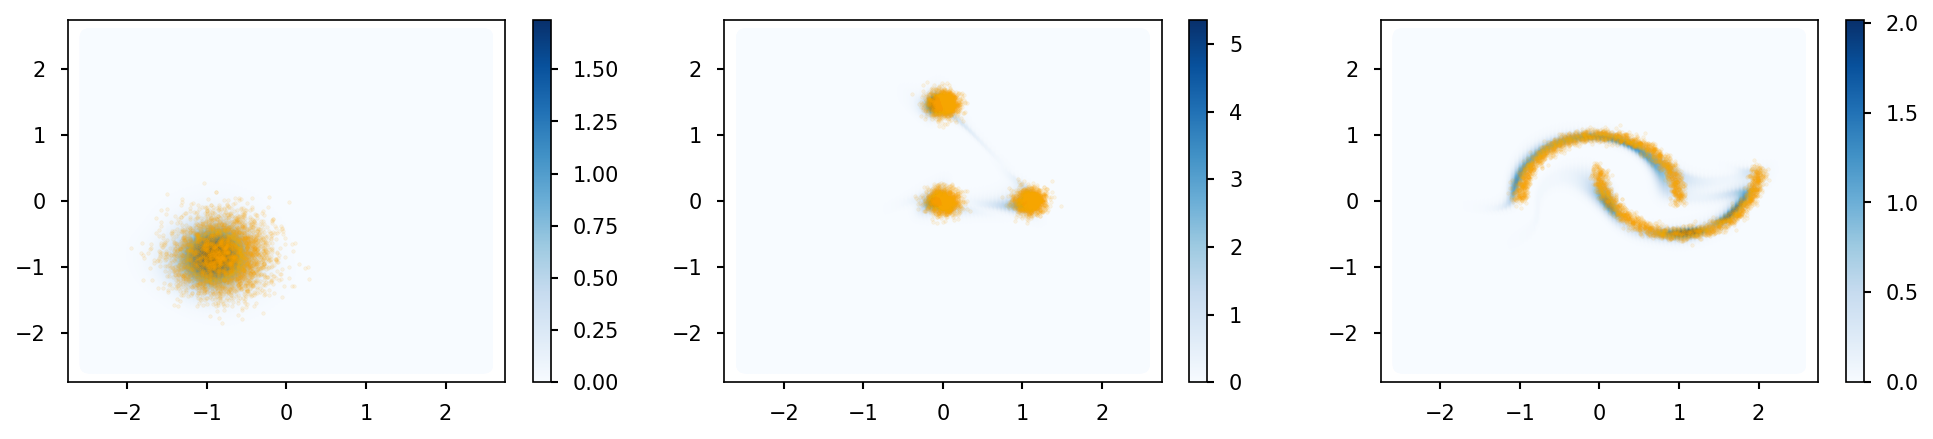

In [7]:
planar_model = xnn.NormalizingFlow([xnn.PlanarTransform(2) for _ in range(16)])
planar_engine = xnn.MLEEngine(planar_model, expects_data_target=False)
train_and_plot_for_all(planar_engine)

### Radial Transform

Dataset (1/3)...
 [Elapsed 0:01:47 | 9.28 it/s]                                                      
Dataset (2/3)...
 [Elapsed 0:01:46 | 9.35 it/s]                                                      
Dataset (3/3)...
 [Elapsed 0:01:47 | 9.31 it/s]                                                      


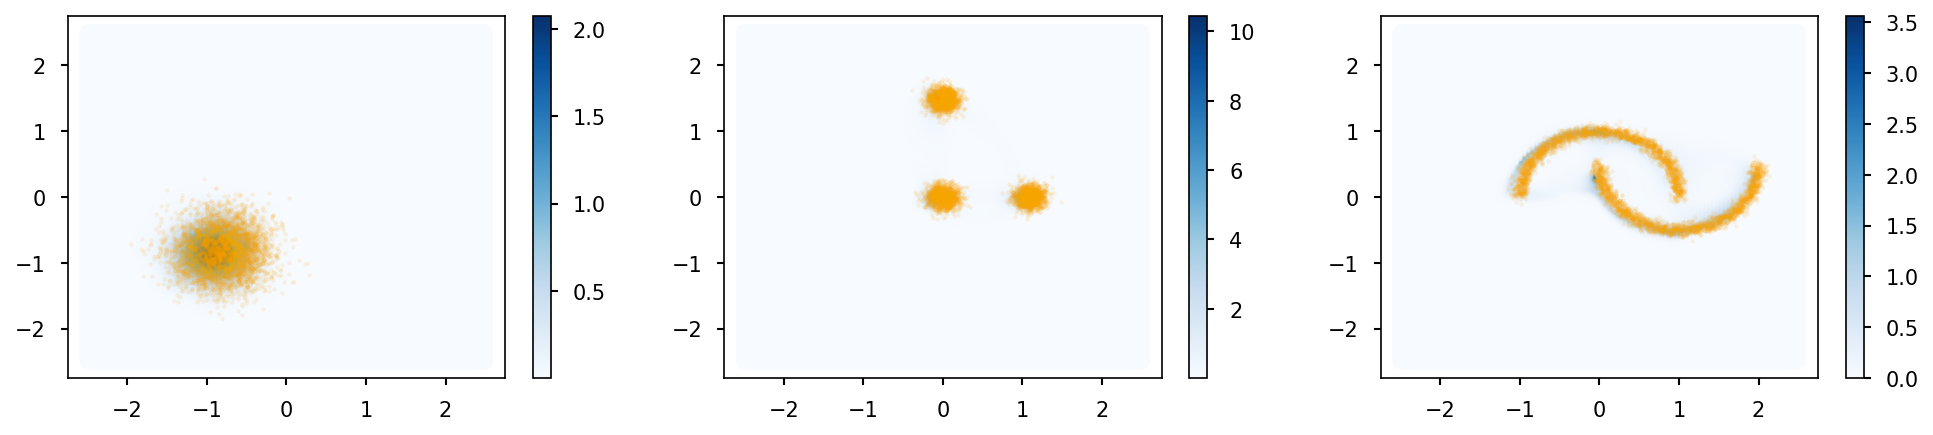

In [8]:
radial_model = xnn.NormalizingFlow([xnn.RadialTransform(2) for _ in range(32)])
radial_engine = xnn.MLEEngine(radial_model, expects_data_target=False)
train_and_plot_for_all(radial_engine)

### Affine Coupling

In [9]:
class NN(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super().__init__()
        
        self.mean = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dim)
        )
        self.logvar = nn.Sequential(
            nn.Linear(in_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, out_dim)
        )
        
    def forward(self, x):
        return self.mean(x), self.logvar(x)

In [10]:
affine_coupling_model = xnn.NormalizingFlow([
    xnn.AffineCouplingTransform1d(2, 1, NN(1, 1), reverse=False),
    xnn.AffineCouplingTransform1d(2, 1, NN(1, 1), reverse=True),
    xnn.AffineCouplingTransform1d(2, 1, NN(1, 1), reverse=False),
    xnn.AffineCouplingTransform1d(2, 1, NN(1, 1), reverse=True),
])

Dataset (1/3)...
 [Elapsed 0:00:52 | 18.92 it/s]                                                      
Dataset (2/3)...
 [Elapsed 0:00:52 | 18.88 it/s]                                                      
Dataset (3/3)...
 [Elapsed 0:00:51 | 19.24 it/s]                                                      


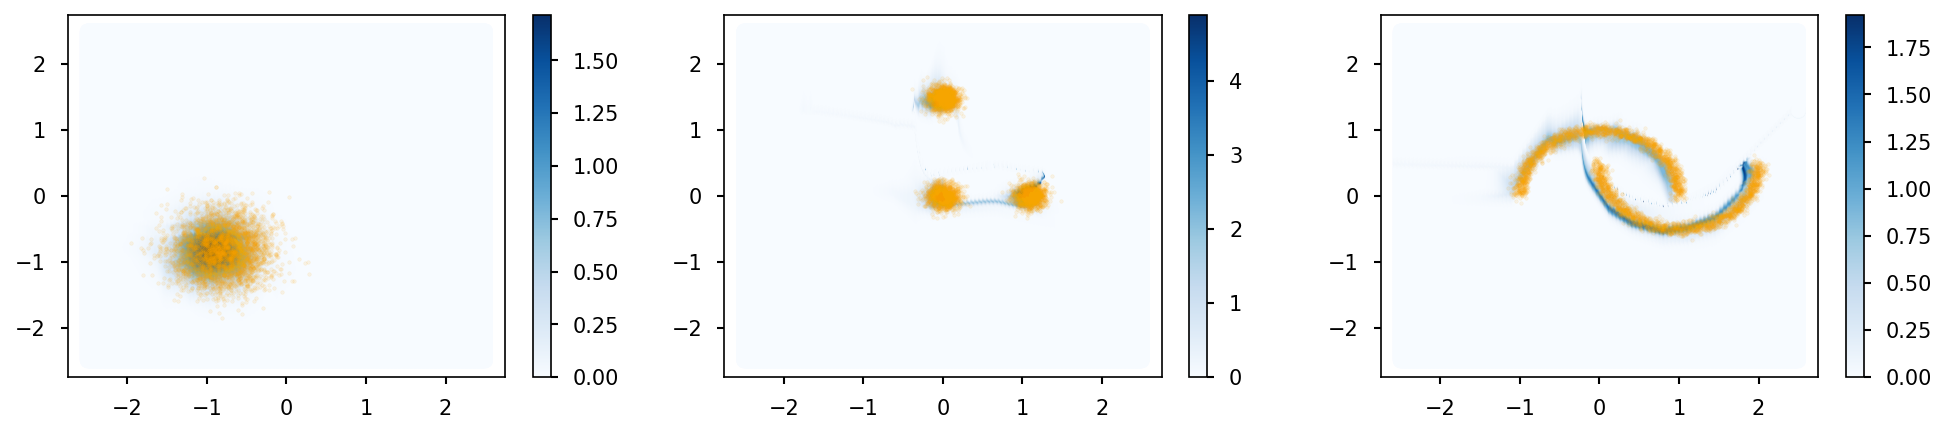

In [11]:
affine_coupling_engine = xnn.MLEEngine(affine_coupling_model, expects_data_target=False)
train_and_plot_for_all(affine_coupling_engine)